# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import torch
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as f
from torchvision import datasets, models, transforms

import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
from collections import OrderedDict
from typing import Iterable
from collections import Counter
# from efficientnet_pytorch import EfficientNet


'''
model = EfficientNet.from_pretrained('efficientnet-b0')
model = models.resnet18()
model = models.vgg16()
print(model)
'''

# these are constants from the network
# ANY CHANGES NEED TO BE MADE IN BOTH PLACES
image_size = 72 # 277        # Standardize all images to a square of this size
depth = 64
pool_size = 2
fc_size_1 = 4096
fc_size_2 = 1024
fc_size_out = 1024
dropout_pct = 0.25

num_workers = 0         # number of subprocesses to use for data loading
batch_size = 37         # how many samples per batch to load
validation_ratio = 0.2  # percentage of training set to use as validation
image_base_dir = r'./landmark_images/'

In [2]:
import requests
import io
import zipfile
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        thezip.extractall('./')
                
# download_extract_zip(r'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip')

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# convert data to a normalized torch.FloatTensor
training_transform = transforms.Compose([
    # don't know if the images are landscape or portrate, or how the image is uploaded.
    # also don't know the purpose of the image, if it is artistic from a strange angle.
    transforms.RandomRotation(degrees=(-75,75)),
    # the first part of the transform is to standardize the image size
    transforms.Resize(image_size+20),
    transforms.CenterCrop(image_size),
    # make this a tensor (rgb,h,w)
    transforms.ToTensor()
    # The images are assumed to be in RGB of unknown color depth
    # 8 bit colors will have values between 0-255, but colors can go to 48 bit or more.
    # The normalization step will ensure that the values are in a consistent range.
    # Using a mean of 0.5 and stdev of 0.5, the normalization will result in a value between 0-1
    # since we are dealing with RGB, we need 3 or each
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Resize(image_size+20),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

loaders_scratch = {}
# training and testing images are in separate folders
# the training data is split into training and validation data
# what is desired is three sets of data where images are mutually exclusive
# training and validation pass through the same transform. I don't really like this.
test_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'./test/'), transform=transform)
train_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'./train/'), transform=training_transform)
final_test_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'./final_test/'), transform=training_transform)

# to split the training data into training and validation data
# it is actually the indecies that are split.
# this will shuffle the indecies randomly, and then split the list based on the validation_ratio
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
split = int(len(train_dataset) * validation_ratio)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# now there can be three loaders for training, testing, and validation images. 
# here the sampler parameter accepts the list of indecies that are allowed to be returned from the loader
loaders_scratch['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
loaders_scratch['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
loaders_scratch['valid'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

loaders_scratch['final_test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for batch_idx, (data, target) in enumerate(loaders_scratch['train']):
    print(batch_idx,target)
    break
    
# print(dict(loaders_scratch))
# print(len(loaders_scratch['test']))
# print(len(loaders_scratch['train']))
# print(len(loaders_scratch['valid']))
# print(len(train_dataset.classes),train_dataset.classes)


0 tensor([22, 26, 12, 39, 15, 31, 16, 33, 24, 32, 38, 21, 17, 18, 38, 47, 42, 48,
        46,  8, 28,  4, 34, 34,  1, 43, 20, 32, 48,  0, 35, 25,  0, 46,  8, 27,
         3])


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

---
**Answer**: <br />
<font face = "Roboto" style="font-style:italic;" size="3 em">
* set up config parameters
* define transforms
    * training transform has a random +/- 75 degree rotation, testing does not have a totation
    * images are resized for uniformity to 224x224 (following VGG16)
    * values are normalized for uniformity
* training set is split into a training and validation set
    (It would be nice to control the rotation of all three of the image sets. I'll save that for later as time permits.)

Image resize is handled in the transform, and will result in a square image (stretching or squishing as needed.  
In the training set, images were randomly rotated 75 degrees, to handle landscape/portrate formats, 
uploading orientation errors, artistic shots from strange angles, etc.
The image is also center cropped just a bit to remove padding post rotation.
</font><br/>
---

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

<ipython-input-4-ea80a17f485f>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, display_count/2, idx+1, xticks=[], yticks=[])


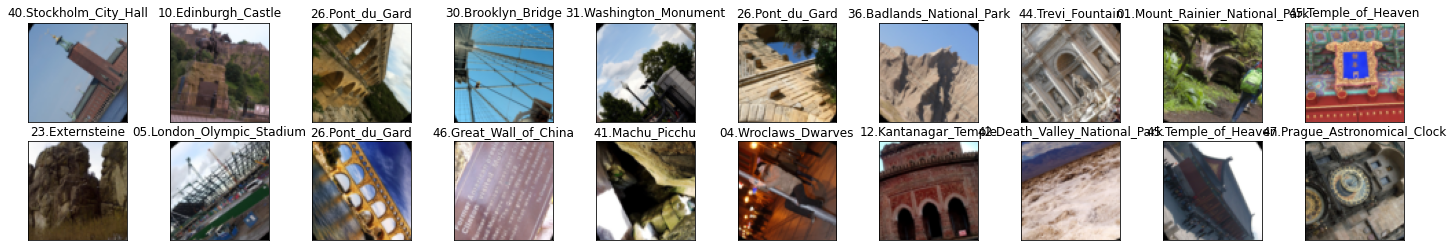

In [4]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
display_count = min(batch_size,20)
for idx in np.arange(display_count):
    ax = fig.add_subplot(2, display_count/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [5]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda: print('CUDA is not available.  Training on CPU ...')
else:            print('Training on NVidia CUDA Driver ...')

CUDA is not available.  Training on CPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
criterion_scratch = nn.NLLLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0007)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

---
CNN architectures have been rapidly changing over the past decade. In order to reinforce my own understanding, I'm starting with an architecture that is easier to comprenend. That is the <a href='https://towardsdatascience.com/google-landmark-recognition-using-transfer-learning-dde35cc760e1'>VGG16</a> architecture.<br/>
<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" alt="VGG16"/>

In [7]:
'''
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # these are constants defined as globals above
        # ANY CHANGES NEED TO BE MADE IN BOTH PLACES
        depth = 64
        
        pool_size = 2
        fc_size_1 = 4096
        fc_size_2 = 1024
        fc_size_out = 1024
        dropout_pct = 0.55
        
        self.relu = nn.ReLU(inplace=True)
        self.Conv2d2_64 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.Conv2d64_64 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.Conv2d64_128 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.Conv2d128_128 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.Conv2d128_256 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.Conv2d256_256 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.Conv2d256_512 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.Conv2d512_512 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.Conv2d512_4096 = nn.Conv2d(512, 4096, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_pct, inplace=False)

        # Feature Layers
        self.features = nn.Sequential(
            # initial feature depth is 3 for RGB, this is expanded to size depth
            
            # Layer 0
            self.Conv2d2_64,self.relu,
            
            # Layer 1
            self.Conv2d64_64,self.relu,
            self.Conv2d64_128,self.relu,

            # Layer 2
            self.maxpool,
            self.Conv2d128_128,self.relu,
            self.Conv2d128_128,self.relu,
            self.Conv2d128_256,self.relu,

            # Layer 3
            self.maxpool,
            self.Conv2d256_256,self.relu,
            self.Conv2d256_256,self.relu,
            self.Conv2d256_256,self.relu,
            self.Conv2d256_512,self.relu,

            # Layer 4
            self.maxpool,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,

            # Layer 5
            self.maxpool,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,
            self.Conv2d512_512,self.relu,

            # Layer 6
            self.maxpool,
            self.Conv2d512_512,self.relu,
            nn.Flatten(start_dim=1)
        )
        
        # Feature Layers
        self.classifier = nn.Sequential(
            # Fully Connected Layers
            nn.Linear(int(7 * 7 * 512), fc_size_1),
            self.relu,self.dropout,
            nn.Linear(fc_size_1, fc_size_2),
            self.relu,self.dropout,
            nn.Linear(fc_size_2, fc_size_2),
            self.relu,self.dropout,
            nn.Linear(fc_size_2, fc_size_2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x
'''

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # these are constants defined as globals above
        # ANY CHANGES NEED TO BE MADE IN BOTH PLACES
        depth = 64
        
        pool_size = 2
        fc_size_1 = 4096
        fc_size_2 = 1024
        fc_size_out = 1024
        dropout_pct = 0.50
        
        self.relu = nn.ReLU(inplace=True)
        self.Conv2d2_64 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.Conv2d64_192 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        self.Conv2d192_384 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.Conv2d384_256 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.Conv2d256_256 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, dilation=1)
        self.dropout = nn.Dropout(p=dropout_pct, inplace=False)

        # Feature Layers
        self.features = nn.Sequential(
            # initial feature depth is 3 for RGB, this is expanded to size depth
            
            self.Conv2d2_64, self.relu, self.maxpool,
            self.Conv2d64_192, self.relu, self.maxpool,
            self.Conv2d192_384, self.relu, # self.maxpool,
            self.Conv2d384_256, self.relu, # self.maxpool,
            self.Conv2d256_256, self.relu, self.maxpool
        )
        
        # Average Pool
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        
        # Flatten
        self.flatten = nn.Flatten(1,-1)
        
        # Feature Layers
        self.classifier = nn.Sequential(
            # Fully Connected Layers
            self.dropout,nn.Linear(int(6 * 6 * 256), fc_size_1), self.relu,
            self.dropout,nn.Linear(fc_size_1, fc_size_2), self.relu,
            nn.Linear(fc_size_2, fc_size_2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [8]:
print(model_scratch)
alexnet = models.alexnet(pretrained=True)
print()
print(alexnet)

# replace the output layer 
class_counts = len(dict(Counter(sample_tup[1] for sample_tup in loaders_scratch['test'].dataset)))
new_fc = nn.Linear(model_scratch.classifier[6].in_features, class_counts)
model_scratch.classifier[6] = new_fc

print(model_scratch)

Net(
  (relu): ReLU(inplace=True)
  (Conv2d2_64): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (Conv2d64_192): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Conv2d192_384): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d384_256): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2d256_256): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

---
__Answer__: <br />
<font face = "Roboto" style="font-style:italic;" size="3 em">
In art and artificial intelligence, lay something down on the canvas, measure what is wrong, make a correction; then do it again. 

1. Put something on the canvas:
    * Starting from the diagram of the VGG16 model and what I have learned, I tried to build a VGG16 network from scratch. Initially I implemented a single layer at each level (e.g only one 28x28x512 layer), as I was unclear what the 4 boxes actually represented. 
    * At each level the image size was reduced by half (both vertically and horizontally), while the depth was doubled. I used a 2x2 kernel and 2x2 stride for the max pool, and a default for the convolution. 
    * The transition from the convolutional layers to the linear layers was a simple flattening.
    * The fully connected linear layers was then a simple stepdown from 4096 to 1024 (a slight adjustmen from the 1000 category output of VGG16.
    
2. Look at the canvas, look at the subject, and fix the problems:
    * After building out the model, I instanciated a vgg16, and compared the two models.
    * Multiple layers at each level
        * So it turns out that having multiple layers is litterally a convolution layer followed by a convolution layer, each with the same output size. 
        * How many layers are needed at each level? 
    * Level Transitions: Conv2d() and MaxPool2d(). The Convolution layers can be used to change the depth of the model. The MaxPool layers will reduce the size of the image. Given the diagram, which should be first, and which should be second? Looking at the architecture of the vgg16 model, it is not done consistently (not that a picture accurately describes the architecture). But, it is interesting to note. I chose consistency. 
        * Whenever model depth needs to be increased, a convolution layer will be used.
        * When the image size needs to be reduced, a max pool layer will be used. 
        * The depth will be changed as the final step of a given level, and the max pool will be the first of the next level.
    * 7x7 to 1x1. The vgg16 model uses an AdaptiveAvgPool2d (I think?) to reduce the model from 7x7 to 1x1. I opted instead just to flatten the layer.
    * Classification Layers, 1x1x4096 to 1x1x1000
        * I chose to implement 3 layers 1x1x4096, 1x1x1028, 1x1x1028
        * The final output layer was intended to be replaced in order to size the output to the number of data classifications of the actual training/testing set.
    * The model is rather large, and does not run on the Udacity VM. 
        * For training and testing the image data set was greatly reduced to have both fewer classifications and fewer images.
        * A full image set from the test directories, with the limited classifications, was used for the project testing step, for the first part of the poject.
    * Dropout. I noticed that the dropout rate was 50%, which is much higher than the 20% that we used in previous exersizes. But, given that the rapid size reductions in the catigorization layers, creating multiple paths is ideal.
3. Give up on VGG.
    * VGG16 was just too big and too slow.
    * Found AlexNet which was smaller and lighter. 
4. Flattening
    * In initial testing I could not resolve image size with the architecture. It seemed like the architecture required a specific image size. To resolve this I just through in a flattening layer.
    * After looking at the actual source code for AlexNet, there is a flattening layer that is not displayed in the architecture. It exists only in the forward pass, but is not displayed. I can place the flattening layer as the first step of the classifiers, so it does appear when the model definition is displayed. I assume that is is common knowledge and expectyed that there is a flattening layer inbetween the convolution an classification layers.
    * I choose to place the flattening layer in it's own set so it can be seen when displaying the model architecture.
</font><br/>
---

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_btch_cnt = 0.0
    valid_btch_cnt = 0.0
    softmax = nn.LogSoftmax(dim=1)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            train_btch_cnt += 1
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = softmax(model(data))
            
            # calculate the batch loss
            loss = criterion(output, target)
            '''
            print('output[0]')
            print(output[0])
            print('')
            print('target[0]')
            print(target[0])
            print('')
            print('loss')
            print(loss)
            print(loss.item())
            print(loss.data.item())
            print('')
            '''
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss *= batch_idx/(batch_idx+1)
            train_loss += loss.data.item()/(batch_idx+1)
            
            
        ######################    
        # validate the model #
        ######################
        
        # set the model to evaluation mode
        # this is for performance, the optimizer is turned off
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            valid_btch_cnt += 1
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = softmax(model(data))
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update validation loss
            valid_loss *= batch_idx/(batch_idx+1)
            valid_loss += loss.data.item()/(batch_idx+1)
            
            
        # print training/validation statistics 
        print('Epoch: {} \tBatch Count: {},{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_btch_cnt,
            valid_btch_cnt,
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if epoch > 2 and valid_loss_min >= valid_loss: 
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min,valid_loss))
            
            valid_loss_min = valid_loss
    
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # From a previous lesson
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (np.log(n)/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Batch Count: 109.0,27.0 	Training Loss: 4.519282 	Validation Loss: 3.928745
Epoch: 2 	Batch Count: 218.0,54.0 	Training Loss: 3.931400 	Validation Loss: 3.923871
Epoch: 3 	Batch Count: 327.0,81.0 	Training Loss: 3.927036 	Validation Loss: 3.922080
Validation loss decreased (inf --> 3.922080).  Saving model ...
Epoch: 4 	Batch Count: 436.0,108.0 	Training Loss: 3.922481 	Validation Loss: 3.923354
Epoch: 5 	Batch Count: 545.0,135.0 	Training Loss: 3.924911 	Validation Loss: 3.921603
Validation loss decreased (3.922080 --> 3.921603).  Saving model ...
Epoch: 6 	Batch Count: 654.0,162.0 	Training Loss: 3.920455 	Validation Loss: 3.920757
Validation loss decreased (3.921603 --> 3.920757).  Saving model ...
Epoch: 7 	Batch Count: 763.0,189.0 	Training Loss: 3.920831 	Validation Loss: 3.920188
Validation loss decreased (3.920757 --> 3.920188).  Saving model ...
Epoch: 8 	Batch Count: 872.0,216.0 	Training Loss: 3.918023 	Validation Loss: 3.919757
Validation loss decreased (3.920188 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 50

model_scratch.load_state_dict(torch.load('ignore.pt'))

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Batch Count: 109.0,27.0 	Training Loss: 3.914429 	Validation Loss: 3.911654
Epoch: 2 	Batch Count: 218.0,54.0 	Training Loss: 3.880777 	Validation Loss: 3.827551
Epoch: 3 	Batch Count: 327.0,81.0 	Training Loss: 3.809623 	Validation Loss: 3.859143
Validation loss decreased (inf --> 3.859143).  Saving model ...
Epoch: 4 	Batch Count: 436.0,108.0 	Training Loss: 3.795999 	Validation Loss: 3.810869
Validation loss decreased (3.859143 --> 3.810869).  Saving model ...
Epoch: 5 	Batch Count: 545.0,135.0 	Training Loss: 3.797352 	Validation Loss: 3.800169
Validation loss decreased (3.810869 --> 3.800169).  Saving model ...
Epoch: 6 	Batch Count: 654.0,162.0 	Training Loss: 3.774312 	Validation Loss: 3.801512
Epoch: 7 	Batch Count: 763.0,189.0 	Training Loss: 3.757762 	Validation Loss: 3.791101
Validation loss decreased (3.800169 --> 3.791101).  Saving model ...
Epoch: 8 	Batch Count: 872.0,216.0 	Training Loss: 3.746700 	Validation Loss: 3.786897
Validation loss decreased (3.791101 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    valid_btch_cnt = 0
    softmax = nn.LogSoftmax(dim=1)

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['final_test']):
        valid_btch_cnt += 1
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## TODO: update average validation loss 

        # forward pass: compute predicted outputs by passing inputs to the model
        output = softmax(model(data))

        # calculate the batch loss
        loss = criterion(output, target)

        # update validation loss
        test_loss *= batch_idx/(batch_idx+1)
        test_loss += loss.data.item()/(batch_idx+1)
            
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('\nTest Loss: {:.6f}'.format(test_loss))
        print('Test Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)


Test Loss: 3.087763
Test Accuracy: 27% (10/37)

Test Loss: 3.016943
Test Accuracy: 24% (18/74)

Test Loss: 3.166663
Test Accuracy: 20% (23/111)

Test Loss: 3.250307
Test Accuracy: 18% (28/148)

Test Loss: 3.196093
Test Accuracy: 19% (36/185)

Test Loss: 3.278092
Test Accuracy: 18% (42/222)

Test Loss: 3.301649
Test Accuracy: 18% (47/259)

Test Loss: 3.262934
Test Accuracy: 18% (55/296)

Test Loss: 3.276026
Test Accuracy: 18% (60/333)

Test Loss: 3.279496
Test Accuracy: 17% (65/370)

Test Loss: 3.269922
Test Accuracy: 18% (76/407)

Test Loss: 3.282791
Test Accuracy: 18% (81/444)

Test Loss: 3.306168
Test Accuracy: 18% (87/481)

Test Loss: 3.298084
Test Accuracy: 18% (94/518)

Test Loss: 3.320953
Test Accuracy: 17% (98/555)

Test Loss: 3.328505
Test Accuracy: 17% (103/592)

Test Loss: 3.339504
Test Accuracy: 17% (110/629)

Test Loss: 3.357028
Test Accuracy: 17% (117/666)

Test Loss: 3.368020
Test Accuracy: 17% (123/703)

Test Loss: 3.366177
Test Accuracy: 17% (129/740)

Test Loss: 3.378

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
# Choose and load a model 
# Using vgg16 as a start
# Create model that is pretrained
my_vgg16 = models.vgg16(pretrained=True)
print(my_vgg16.features)

# Freeze training for all "features" layers
for param in my_vgg16.features.parameters():
    param.requires_grad = False

# get index of Linear layers
# sans the first Linear Layer
# These are the classification (fully connected) layers,
# and are the ones we want to replace and retrain
linear_layer_i = [i for i,c in enumerate(my_vgg16.classifier) if str(c).find('Linear') != -1]

# Freeze training for first fully connected (linear) layer
for i in linear_layer_i[:1]:
    for param in my_vgg16.classifier[i].parameters():
        param.requires_grad = False

# Enable training of all but the first fully connected (linear) layer
# And re-initialize weights so they can be trained
for i in linear_layer_i[1:]:
    print(my_vgg16.classifier[i].weight)
    for param in my_vgg16.classifier[i].parameters():
        param.requires_grad = True
    custom_weight_init(my_vgg16.classifier[i])
    print(my_vgg16.classifier[i].weight)


print(my_vgg16.features)
'''
print(my_vgg16)
print(my_vgg16.classifier[0])
print(my_vgg16.classifier[0].weight)
print(my_vgg16.classifier[0].in_features) 
print(my_vgg16.classifier[0].out_features)
print(linear_layer_i)
'''

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

'\nprint(my_vgg16)\nprint(my_vgg16.classifier[0])\nprint(my_vgg16.classifier[0].weight)\nprint(my_vgg16.classifier[0].in_features) \nprint(my_vgg16.classifier[0].out_features)\nprint(linear_layer_i)\n'

In [14]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': loaders_scratch['train'], 'valid': loaders_scratch['valid'], 'test': loaders_scratch['test']}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [15]:
## TODO: select loss function
criterion_transfer = criterion_scratch

def get_optimizer_transfer(model): return get_optimizer_scratch(model)
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
## TODO: Specify model architecture

model_transfer = my_vgg16

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 20
model_scratch = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Batch Count: 109.0,27.0 	Training Loss: 209.307227 	Validation Loss: 58.027305
Epoch: 2 	Batch Count: 218.0,54.0 	Training Loss: 117.006597 	Validation Loss: 47.422911
Epoch: 3 	Batch Count: 327.0,81.0 	Training Loss: 88.647542 	Validation Loss: 32.736619
Validation loss decreased (inf --> 32.736619).  Saving model ...
Epoch: 4 	Batch Count: 436.0,108.0 	Training Loss: 68.701033 	Validation Loss: 24.883500
Validation loss decreased (32.736619 --> 24.883500).  Saving model ...
Epoch: 5 	Batch Count: 545.0,135.0 	Training Loss: 53.341241 	Validation Loss: 18.396515
Validation loss decreased (24.883500 --> 18.396515).  Saving model ...
Epoch: 6 	Batch Count: 654.0,162.0 	Training Loss: 45.133142 	Validation Loss: 14.112948
Validation loss decreased (18.396515 --> 14.112948).  Saving model ...
Epoch: 7 	Batch Count: 763.0,189.0 	Training Loss: 38.228472 	Validation Loss: 11.575436
Validation loss decreased (14.112948 --> 11.575436).  Saving model ...
Epoch: 8 	Batch Count: 872.0,

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

